# **Fake News**

<body>
<img src="https://conversationagent.typepad.com/.a/6a00d8341c03bb53ef0147e02d8fa5970b-pi" width="870"/>
</body>

**The Daily Inspector was a popular news agency which was once trusted for its reliable and speedy news coverage with over 4 million readers worldwide.**


**A recent lapse in the news agency’s fact checking policy meant that over 1,000 articles went out within the last 2 months with incorrect information; leading to large criticism and a significant drop in the agency’s number of readers.**

**To rectify this, The Daily Inspector has hired you to find a way of locating these fake articles; so that they can be deleted or corrected, and suggest potential ways they can prevent such a thing from happening again.**


## **1. Import Libraries and Data needed**
<body>
<img src="https://offloadmedia.feverup.com/secretldn.com/wp-content/uploads/2016/06/18075319/Libraries-1024x901.jpg" width="600"/>
</body>

Here we are importing all the libraries that we will need to analyse the data.

Libraries contain all the little functions and tools that other programmers have created. This way we don't have to spend hours recreating code. Instead, we just call out the function name and it performs all the steps we want it to do.

In [ ]:
!pip install contractions

     |████████████████████████████████| 284 kB 6.7 MB/s 
     |████████████████████████████████| 321 kB 54.5 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85451 sha256=f09446402d8a61efc00fdbbde9565826daab582fd292852e835f4901799c5247
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import re
import tensorflow
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

In [ ]:
## Import train dataset
df = pd.read_csv('/content/train.csv',engine='python', encoding='utf-8', error_bad_lines=False)
## Import test dataset
test_data = pd.read_csv('/content/test.csv',engine='python', encoding='utf-8', error_bad_lines=False)

Skipping line 810: unexpected end of data
Skipping line 657: unexpected end of data


## **2. Exploratory Data Analysis & Text Processing**

First let's inspect the data

Note: 

1 = Fake News/Article

0 = Not Fake News/Article


In [ ]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


Let's check if there are any null values in the data!

Models can't make any predictions and we can't make any useful insights with null values in our data.

In [ ]:
df.isnull().sum()

id         0
title     21
author    85
text       2
label      0
dtype: int64

#### **Data Prep**

In [ ]:
# Assign nan in place of blanks in the text column
df['text'] = df['text'].str.strip()
df['text'] = df['text'].replace(r'^\s*$', np.nan, regex=True)

In [ ]:
# Remove all rows where complaints column is nan
df.dropna(subset=['text'], inplace=True)

####**Check for duplicates**

Having duplicates in any data isn't good. But it is especially important to creating effective and accurate models.

Having data with no duplicates ensures that you will develop one, complete version of the truth allowing you to base strategic decisions on accurate data.

In [ ]:
df.duplicated(subset=["text"]).value_counts()

False    799
True       2
dtype: int64

As we can see, we have few duplicate entries for text column

In [ ]:
dup = df[df.duplicated(subset=["text"])]
dup.head()

,id,title,author,text,label
480,480,Watch: Muslim ‘Palestinians’ Declare “We follo...,admin,jewsnews © 2015 | JEWSNEWS | It's not news...u...,1
734,734,WikiLeaks Documents Reveal United Nations Inte...,Madeline,Click Here To Learn More About Alexandra's Per...,1


In [ ]:
# print one duplicate entry
df[df['text'] == dup.loc[480]['text']]

,id,title,author,text,label
372,372,IRANIAN MISSILE ACCIDENTALLY DESTROYS IRANIAN ...,admin,jewsnews © 2015 | JEWSNEWS | It's not news...u...,1
480,480,Watch: Muslim ‘Palestinians’ Declare “We follo...,admin,jewsnews © 2015 | JEWSNEWS | It's not news...u...,1


**Question**

Why would you want to remove these duplicate entries?

####**Drop duplicated Data & Nan values**

In [ ]:
# drop duplicated data
df = df.drop_duplicates(subset={"text"}, keep='first', inplace=False)
df.shape

(799, 5)

####**Replace null values**

In [ ]:
# Checking for missing values in the dataset
df.isnull().sum()

id         0
title     21
author    83
text       0
label      0
dtype: int64

In [ ]:
# dropping the nan values
df = df.fillna('')

In [ ]:
# Now count the Unique values to check the data is balanced or not
count = np.unique(df['label'], return_counts=True)
count

(array([0, 1]), array([404, 395]))

Now let's see that graphically

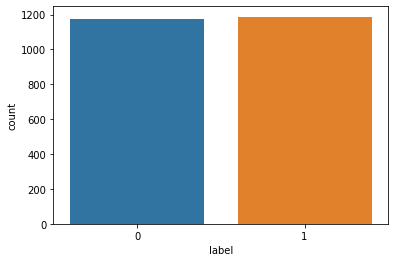

In [ ]:
import seaborn as sns
sns.countplot(x='label', data = df)

####**Extra EDA**

Let's check the 10 authors who created the most articles with fake news and compare them to the top 20 authors who created accurate articles (not fake)

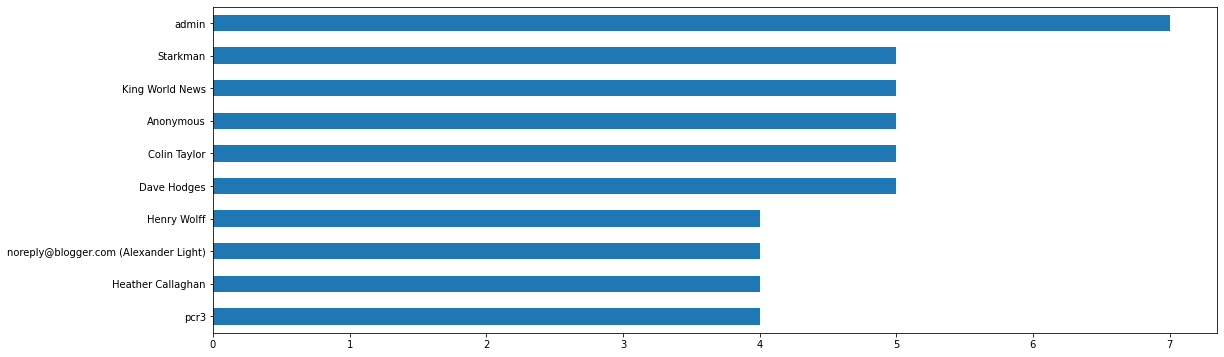

In [ ]:
df.loc[df['label'] == 1]['author'].value_counts()[:10].sort_values().plot(kind = 'barh',figsize=(18,6))

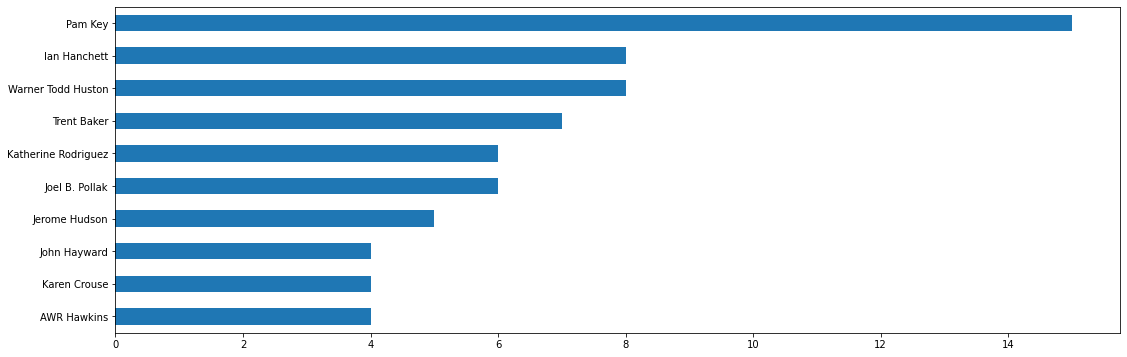

In [ ]:
df.loc[df['label'] == 0]['author'].value_counts()[:10].sort_values().plot(kind = 'barh',figsize=(18,6))

###**Preprocessing Text**

We will perform the below preprocessing tasks:

- Convert everything to lowercase - We don't want our model to think having capitals and non capitals in text are significant indications of an article being fake or not... So let's set everything to lower case.
- Remove HTML tags
- Remove URLs from sentences
- Contraction mapping - This essentially fixes and expands shortened words - you're -> you are
- Eliminate punctuations and special characters
- Remove stopwords - words that are usually irrelevant to the meaning of a piece of text
- Stem words in text - This essentially removes the suffix of a word and gives back the base/root of a word (e.g. Flying becomes Fly)

In [ ]:
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
stopword_list = stopwords.words('english')
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
# let us use the contractions package to fix and expand shortened words - you're -> you are
import contractions
def decontracted(sentance):
    expanded_words = []    
    for word in sentance.split():
      # using contractions.fix to expand the shortened words
      expanded_words.append(contractions.fix(word))   

    expanded_text = ' '.join(expanded_words)
    return expanded_text

In [ ]:
def sentence_clean(sentence):
    # change sentence to lower case
    sentence = sentence.lower()
    # removing URL from sentence
    sentence = re.sub(r"http\S+", "", sentence)
    # removing HTML tags
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    # removing contraction of words from sentence   # call decontracted funtion for it
    sentence = decontracted(sentence)
    # removing digits
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    # removing special character
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    
    return sentence

In [ ]:
# Use Stemming 
ps = PorterStemmer()

# Performing the preprocessing steps on all messages
def preprocess(document):
    preprocessed_reviews = []
    # tqdm is for printing the status bar
    for sentence in tqdm(document):
        # call sentance_clean function to clean text
        sentence = sentence_clean(sentence)
        # tokenize into words
        words = word_tokenize(sentence)
        # remove stop words
        tokens = [ps.stem(word) for word in words if word not in stopword_list]

        # join words to make sentence
        sentence = " ".join(tokens).strip()

        preprocessed_reviews.append(sentence)
        
    return preprocessed_reviews

In [ ]:
%%time
corpus = preprocess(df['text'])

100%|██████████| 799/799 [00:17<00:00, 46.40it/s]

CPU times: user 17 s, sys: 81.7 ms, total: 17.1 s
Wall time: 17.2 s


#### **Try to spot the differences in the text!**

What has stemming the words done?

In [ ]:
print("Before preprocess\n", df['text'][1])
print("***"*40)
print("After preprocess\n", corpus[1])

Before preprocess
 Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie

In [ ]:
df['text'] = corpus

## **3. Build Our Training And Test Data**
<body>
<img src="https://clearmeasure.com/wp-content/uploads/2018/11/build-1159776_960_720.jpg"/>
</body>

**In this section we are seperating our data between our X and y.**

- X will be the data the model recieves and in turn makes a prediction.

- y will be the data the model will compare its prediction to i.e. the data the model marks itself against

**Then the data will be split into training data and test data.**

Depending on how much data you have (the more the better), we split it into our training & test data. This means we create a training data to test data ratio between 0.7 to 0.3 and 0.8 to 0.2.

We want to give our model plenty of data to learn from but we also need to give it enough unseen tests for it to accurately gauge its predictive ability.



<details>
  <summary>Parameters you can change:</summary>

  - test_size - As stated before, this parameter will determine your training data to test data ratio.

    -  0.5 means that we are creating a 50/50 split between training and test data
    - 0.25 means that we are creating a 75/25 split between training and test data
</details>

In [ ]:
# Seperating the data and the label 
X = df['text']
y = df['label']

In [ ]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [ ]:
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (399,)
Test size: (400,)


##**4. Create our Model**
<body>
<img src="https://scx2.b-cdn.net/gfx/news/hires/2019/howtoovercom.jpg" width="870"/>
</body>

For our fake news detection model, we will be using a logistic regression model.

In simple terms,Logistic Regression is a statistical model used to model the probability of an event existing i.e. what is the probability that you will win or loose (in this example an article being real or fake)

In [ ]:
def plot_confusion_matrix(y_actual, y_pred):
    '''
    This method plots confusion matrix.
    '''
    classes = ['Fake News', 'Real News']
    tick_marks = np.arange(len(classes))

    accuracy = accuracy_score(y_actual, y_pred)
    print("Accuracy score:", "{:2.3}".format(accuracy))

    conf_matrix = confusion_matrix(y_actual, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(conf_matrix, cmap=plt.cm.Reds, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
    
    plt.tight_layout()
    plt.xticks(tick_marks , classes, rotation=0)
    plt.yticks(tick_marks , classes)
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Confusion Matrix', fontsize=12)
    plt.show()

### **TF-IDF Vectorizing**
<body>
<img src="https://miro.medium.com/max/1400/1*qQgnyPLDIkUmeZKN2_ZWbQ.png" width="870"/>
</body>


In similar terms as the image says above, **TF-IDF** (**Term Frequency- Inverse Document Frequency**), is a numerical statistic reflecting how important a word is to a document in a collection. We can use this to pick out words that appear to be important in our test article. These will be used as our features - words that the model will use to learn if an article is fake or not.


**Don't worry you don't have to know any formulas for this!!**


<details>
  <summary>Parameters you can change:</summary>

  - n_gram - This parameter picks out our features in ranges from 1 to n (1,n). 

    -  (1,1) means that only one word features will be extracted and used as features.
    -  (1,2) means that one word and two word terms will be extracted and used as features.
    -  (1,2) means that one word, two word and three word terms will be extracted and used as features.

**Example**

  Text = "I am writing this text as an example to show you the importance of tf-idf vectorizers"
  1. n_gram(1,1) might pick out words like ["writing","example"...] etc

  2. n_gram(1,2) might pick out words like ["writing", "writing this","example"...] etc

  3. ne_gram(1,3) might pick out words like ["importance", importance of", importance of tf-idf"...] etc
</details>

In [ ]:
#test out n_gram range
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf.fit(X) # adjust our vectorizer to the data we have

#Now convert the data into their tfidf representations
X_train_cv = tfidf.transform(X_train)
X_test_cv = tfidf.transform(X_test)

len(tfidf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


593452

In [ ]:
# Create our logistic regression object/model object and fit it to our training data
model = LogisticRegression()
model.fit(X_train_cv, y_train)

LogisticRegression()

In [ ]:
#predict on training data
X_train_predict = model.predict(X_train_cv)
#Let's see our training accuracy
train_accuracy = accuracy_score(y_train, X_train_predict)

#predict on our test data
X_test_predict = model.predict(X_test_cv)
#Let's see our test accuracy
test_accuracy = accuracy_score(y_test, X_test_predict)

In [ ]:
accuracy = accuracy_score(y_test, X_test_predict)
LR_TF_TFIDF = {'Vectorizer': 'TF-IDF', 'Algorithm': 'Logistic_Regression_1', 
               'Train Accuracy':train_accuracy, 'Test Accuracy':test_accuracy}

In [ ]:
LR_TF_TFIDF

{'Algorithm': 'Logistic_Regression_1',
 'Test Accuracy': 0.85,
 'Train Accuracy': 1.0,
 'Vectorizer': 'TF-IDF'}

Understanding our model's performance with a confusion matrix helps us to see exactly how our model performed.
A confusion helps to identify where the model made false positives and false negatives compared to the correct answers.

Accuracy score: 0.85


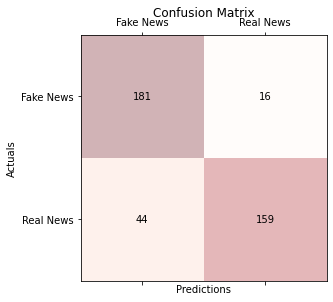

In [ ]:
# plot confusion matrix on test
plot_confusion_matrix(y_test, X_test_predict)

## **5. Test our model**

Let us test our model with our own examples and some examples from the training and test data!

In [ ]:
def classify_message(text):
    text = tfidf.transform(text)
    predicted = model.predict(text)
    probability = model.predict_proba(text).max()*100

    if predicted==0:
      print(" I am "+ str(round(probability))+"% sure that this is not Fake news")
    else:
      print(" I am "+ str(round(probability))+"% sure that this news is Fake")

In [ ]:
test2 = ["Share a certain post of Bill Gates on Facebook and he will send you money."]

In [ ]:
classify_message(test2)

 I am 55% sure that this news is Fake


In [ ]:
df[['title','text','label']]

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,hous dem aid even see comey letter jason chaff...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",ever get feel life circl roundabout rather hea...,0
2,Why the Truth Might Get You Fired,truth might get fire octob tension intellig an...,1
3,15 Civilians Killed In Single US Airstrike Hav...,video civilian kill singl us airstrik identifi...,1
4,Iranian woman jailed for fictional unpublished...,print iranian woman sentenc six year prison ir...,1
...,...,...,...
803,North Korean Is Arrested in Killing of Kim Jon...,kuala lumpur malaysia man north korea arrest a...,0
804,SURGEONS ADMIT THAT MAMMOGRAPHY IS OUTDATED AN...,home health surgeon admit mammographi outdat h...,1
805,Le terrorisme régional protège Israël,le terrorism r gional vise prot ger le int r t...,1
806,WAR ON THE STREETS OF PARIS: Armed migrants fi...,wmw admin novemb nick gutteridg daili express ...,1


In [ ]:
classify_message([df['text'][1]])

 I am 53% sure that this news is Fake


###**Apply it to our test data**


In [ ]:
def classify_message(text):
    text = tfidf.transform(text)
    predicted = model.predict(text)
    probability = model.predict_proba(text).max()*100

    if predicted==0:
      return("Not Fake")
    else:
      return("Fake")

In [ ]:
def prediciton_score(text):
    text = tfidf.transform(text)
    predicted = model.predict(text)
    return predicted

In [ ]:
#create a new column called prediction with no data
test_data['prediction'] = " "
#create a new column called prediction_score with no data
test_data['prediction_score'] = " "

In [ ]:
test_data = test_data.fillna('')

In [ ]:
#create a for loop which takes in data from the text column and returns a prediction as to whether the news is fake or not
for i in range (len(test_data)):
  test_data['prediction'][i] = classify_message([test_data['text'][i]])
  test_data['prediction_score'][i] = prediciton_score([test_data['text'][i]])

In [ ]:
test_data

,id,title,author,text,prediction,prediction_score
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",Not Fake,[0]
1,20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...,Fake,[1]
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,Not Fake,[0]
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",Not Fake,[0]
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,Fake,[1]
...,...,...,...,...,...,...
650,21450,Scientists Told To ‘Remain Silent’ On Glyphosa...,Starkman,The World Health Organization (WHO) have told ...,Not Fake,[0]
651,21451,Michael Moore Owes Me $4.99,shorty,Where to Invade Next Official Trailer 1 (2016)...,Fake,[1]
652,21452,Rare ’Pink Star’ Diamond Becomes Priciest Diam...,Katherine Rodriguez,A 59. 6 carat pink diamond broke the world rec...,Not Fake,[0]
653,21453,Mom Has Powerful Response for Haters Who Say D...,Prudence Hill,Share on Twitter \nSonia Morales didn't hesita...,Not Fake,[0]
